In [1]:
import sys

sys.path.append("../../src/groundstate_prep")
from ground_state_prep_qiskit import get_error_from_sv, prepare_ground_state_qiskit
from utils_gsp import approx_polynomial, get_phis, U

sys.path.append("../../src/lindbladian")
from lindbladian import ideal_lindbladian, circuit_implementation_lindbladian
from utils_lind import crandn

In [2]:
# Hamiltonian.

import numpy as np
from numpy import linalg as LA
import qib
import matplotlib.pyplot as plt

# Parameters for the Ising Hamiltonian
# L has to be even! Due to K only being able to control even Ls!
L, J, g = (6, 1, 1)


# construct Hamiltonian
latt = qib.lattice.IntegerLattice((L,), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
hamil = qib.IsingHamiltonian(field, J, 0, g).as_matrix().toarray()

eigenvalues, eigenvectors = LA.eig(hamil)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]
print("Ground State Energy", eigenvalues_sort[0].real)

Ground State Energy -7.727406610312517


Absolute Error for the Eigenvalue:  0.4731727540735058
State fidelity to the ground state:  0.7585850631971753


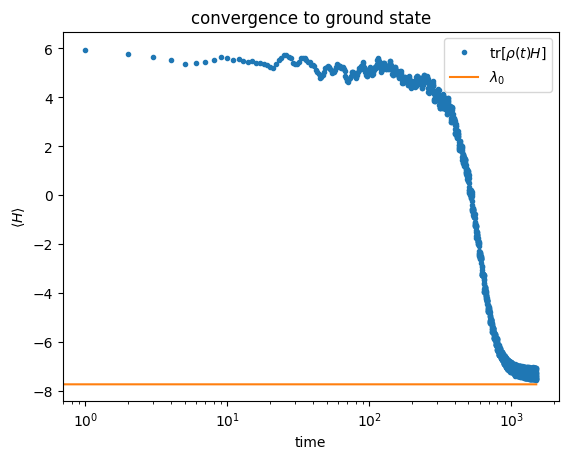

In [3]:
from qiskit.quantum_info import state_fidelity

tau, nsteps = (1, 1500)
end_state_lind, en_list, err = circuit_implementation_lindbladian(hamil, L, tau=tau, nsteps=nsteps)

print("Absolute Error for the Eigenvalue: ", err)
print("State fidelity to the ground state: ", state_fidelity(end_state_lind, ground_state))
plt.semilogx(tau * np.arange(nsteps + 1), en_list, ".", label=r"$\mathrm{tr}[\rho(t) H]$")
plt.semilogx(tau * np.arange(nsteps + 1), (eigenvalues_sort[0]*np.ones(nsteps + 1)).real, label=r"$\lambda_0$")
plt.legend()
plt.xlabel("time")
plt.ylabel(r"$\langle H \rangle$")
plt.title("convergence to ground state")
plt.show()

In [4]:
# Linear transformation of the hamiltonian to fit the eigenvalues in the [-1, 1] interval.

dist = 0.001

# Have to be guessed, depending on the used Hamiltonian
# If we have a good initial overlap, we can decrease this 
# max_spectrum_length and get a larger spectral gap after transformation.
max_spectrum_length = 16
ground_energy_lower_bound = -9
c1 = (np.pi-2*dist) / (max_spectrum_length)
c2 = dist - c1 * ground_energy_lower_bound

eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])

print("a_max", a_values[0])
print("a_premax", a_values[1])
print("c1: ", c1)
print("c2: ", c2)
print("t: ", 0.5*c1)

a_max (0.9921530917736707-0j)
a_premax (0.9885924745552997-0j)
c1:  0.19622454084936208
c2:  1.7670208676442587
t:  0.09811227042468104


In [5]:
mu, d, c, phis_max_iter, = (0.99, 30, 0.95, 10)
ket_0 = np.array([1,0])

qc_RQC, qc_H_RQC, qc_STR, qc_H_STR = prepare_ground_state_qiskit(
                       L, J, g, c1/2, mu, a_values, c2, 3, init_state=np.kron(ket_0, end_state_lind)
)

Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.2814077874002102+0j)
Layer  0
Layer  1
Layer  2
Layer  0
Layer  1
Layer  2


In [8]:
err, reps, shots = (1e-10, 1, 1e5)

print(f"RQC, (Depolar. Error: {err}, t1 = 3e8, t2 = 3e8, gate_t = 0), L=6, nshots={shots}: ", get_error_from_sv(qc_RQC, qc_H_RQC, err, reps, L, J, g, 
                                    eigenvalues_sort[0], nshots=shots, t1=3e8, t2=3e8, gate_t=0))
print(f"Strang-3, (Depolar. Error: {err}, t1 = 3e8, t2 = 3e8, gate_t = 0), L=6, nshots={shots}: ", get_error_from_sv(qc_STR, qc_H_STR, err, reps, L, J, g, 
                                    eigenvalues_sort[0], nshots=shots, t1=3e8, t2=3e8, gate_t=0))

getting counts
gotten counts
-7.721680000000001
RQC, (Depolar. Error: 1e-10, t1 = 3e8, t2 = 3e8, gate_t = 0), L=6, nshots=100000.0:  0.0057266103125162005
getting counts
gotten counts
-7.711419999999999
Strang-3, (Depolar. Error: 1e-10, t1 = 3e8, t2 = 3e8, gate_t = 0), L=6, nshots=100000.0:  0.01598661031251858


In [9]:
err, reps, shots = (1e-4, 1, 1e5)

print(f"RQC, (Depolar. Error: {err}, t1 = 3e8, t2 = 3e8, gate_t = 0), L=6, nshots={shots}: ", get_error_from_sv(qc_RQC, qc_H_RQC, err, reps, L, J, g, 
                                    eigenvalues_sort[0], nshots=shots, t1=3e8, t2=3e8, gate_t=0))
print(f"Strang-3, (Depolar. Error: {err}, t1 = 3e8, t2 = 3e8, gate_t = 0), L=6, nshots={shots}: ", get_error_from_sv(qc_STR, qc_H_STR, err, reps, L, J, g, 
                                    eigenvalues_sort[0], nshots=shots, t1=3e8, t2=3e8, gate_t=0))

getting counts
gotten counts
-7.605599999999998
RQC, (Depolar. Error: 0.0001, t1 = 3e8, t2 = 3e8, gate_t = 0), L=6, nshots=100000.0:  0.12180661031251905
getting counts
gotten counts
-7.612279999999996
Strang-3, (Depolar. Error: 0.0001, t1 = 3e8, t2 = 3e8, gate_t = 0), L=6, nshots=100000.0:  0.11512661031252147


In [10]:
err, reps, shots = (1e-3, 1, 1e5)

print(f"RQC, (Depolar. Error: {err}, t1 = 3e8, t2 = 3e8, gate_t = 0), L=6, nshots={shots}: ", get_error_from_sv(qc_RQC, qc_H_RQC, err, reps, L, J, g, 
                                    eigenvalues_sort[0], nshots=shots, t1=3e8, t2=3e8, gate_t=0))
print(f"Strang-3, (Depolar. Error: {err}, t1 = 3e8, t2 = 3e8, gate_t = 0), L=6, nshots={shots}: ", get_error_from_sv(qc_STR, qc_H_STR, err, reps, L, J, g, 
                                    eigenvalues_sort[0], nshots=shots, t1=3e8, t2=3e8, gate_t=0))

getting counts
gotten counts
-6.664060000000001
RQC, (Depolar. Error: 0.001, t1 = 3e8, t2 = 3e8, gate_t = 0), L=6, nshots=100000.0:  1.0633466103125162
getting counts
gotten counts
-6.667480000000001
Strang-3, (Depolar. Error: 0.001, t1 = 3e8, t2 = 3e8, gate_t = 0), L=6, nshots=100000.0:  1.059926610312516
